In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from sklearn.naive_bayes import GaussianNB
import os

In [27]:
training_data_X = pd.read_csv('training_data_X.csv')
training_data_Y = pd.read_csv('training_data_Y.csv')
test_data_X = pd.read_csv('test_data_X.csv')
print(training_data_X.shape)

(486254, 22)


1. Data visualization

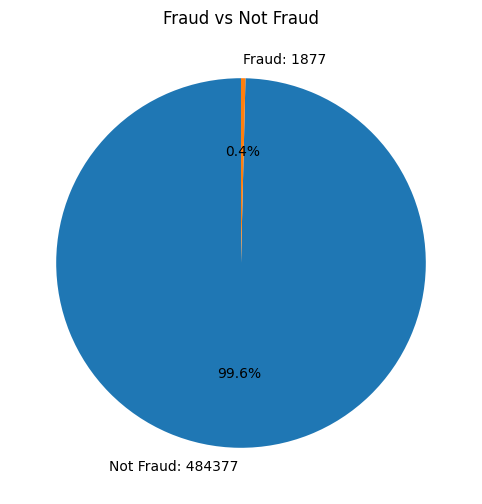

In [28]:
fraud_count = training_data_Y['is_fraud'].value_counts()
fraud = fraud_count[1]
not_fraud = fraud_count[0]
plt.figure(figsize=(8, 6))
plt.pie(fraud_count, labels=[f"Not Fraud: {not_fraud}", f"Fraud: {fraud}"], autopct='%1.1f%%', startangle=90)
plt.title('Fraud vs Not Fraud')
plt.show()

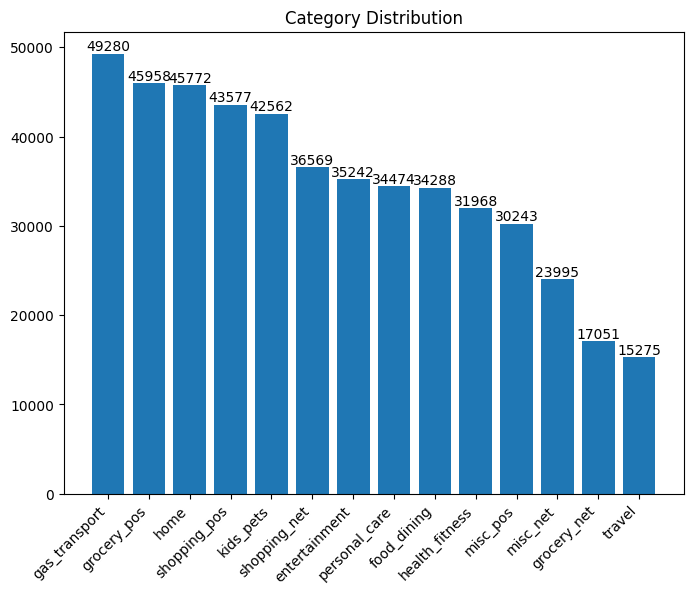

In [29]:
category_count = training_data_X['category'].value_counts()
plt.figure(figsize=(8, 6))
bar = plt.bar(category_count.index, category_count.values)
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{height}', ha='center', va='bottom')
plt.title('Category Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()


1. the Relationship of {cc_num, is_fraud}

In [30]:
# merge X['cc_num'] and Y['is_fraud']

cc_num_fraud = pd.concat([training_data_X.set_index('Id'), training_data_Y], axis=1)

fraud_counts_per_cc = cc_num_fraud.groupby(['cc_num', 'is_fraud']).size().unstack(fill_value=0)

fraud_counts_per_cc.head()


is_fraud,0.0,1.0
cc_num,,
6.041621e+10,526,1
6.042293e+10,497,3
6.042310e+10,168,1
6.042785e+10,163,2
6.048700e+10,188,0


In [31]:
top_fraud_cc = fraud_counts_per_cc.sort_values(by=1.0, ascending=False).head(15)

top_fraud_cc

is_fraud,0.0,1.0
cc_num,,
2.131740e+14,990,11
2.131580e+14,822,11
4.792630e+18,978,9
3.541160e+15,918,8
4.746000e+12,1104,8
4.908850e+15,1014,8
6.011370e+15,1652,7
4.861310e+18,849,7
3.560800e+15,998,7


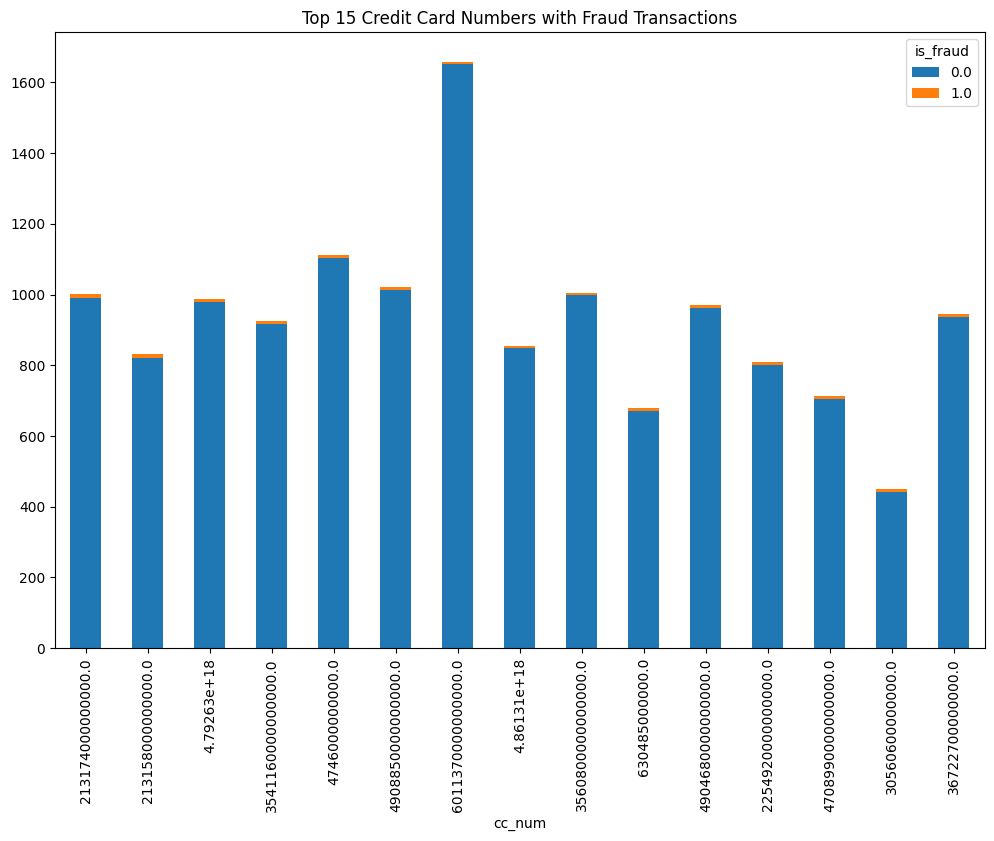

In [32]:
top_fraud_cc.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Top 15 Credit Card Numbers with Fraud Transactions')
plt.show()

2. the Relationship of {(cc_num, date0), is_fraud}

In [62]:
merged_data = pd.concat([training_data_X,training_data_Y], axis=1)

merged_data['date'] = pd.to_datetime(merged_data['trans_date_trans_time'],format="%d/%m/%Y %H:%M").dt.date

fraud_stats = merged_data.groupby(['cc_num', 'date', 'is_fraud']).size().reset_index(name='count')

grouped_stats = fraud_stats.pivot_table(index=['cc_num', 'date'], columns='is_fraud', values='count', fill_value=0).reset_index()

grouped_stats.columns = ['cc_num', 'date', 'non_fraud_count', 'fraud_count']


top_15_fraud_cases = grouped_stats.sort_values(by='fraud_count', ascending=False).head(15)

print(top_15_fraud_cases)

              cc_num        date  non_fraud_count  fraud_count
106715  4.599290e+15  2020-10-25              0.0         14.0
87415   3.577790e+15  2020-08-02              0.0         11.0
78201   3.545110e+15  2020-12-08              0.0         11.0
89783   3.588000e+15  2020-12-02              0.0         10.0
127662  6.538440e+15  2020-11-20              0.0         10.0
17327   4.586260e+12  2020-09-14              0.0         10.0
106927  4.607070e+15  2020-12-12              0.0         10.0
68035   3.501940e+15  2020-10-15              0.0         10.0
31143   3.054650e+13  2020-11-25              0.0         10.0
11640   4.026220e+12  2020-11-01              0.0         10.0
39419   1.800990e+14  2020-06-24              0.0         10.0
43539   2.131810e+14  2020-12-08              0.0         10.0
88820   3.585050e+15  2020-10-04              0.0          9.0
91613   3.596220e+15  2020-12-11              0.0          9.0
39776   2.131120e+14  2020-08-18              0.0      

3. KNN

In [63]:
# only use cc_num, trans_date and is_fraud
merged_data['date'] = pd.to_datetime(merged_data['trans_date_trans_time'], format="%d/%m/%Y %H:%M")

merged_data['date_str'] = merged_data['date'].dt.strftime('%Y%m%d')

merged_data['date_decimal'] = merged_data['date_str'].astype(int)


In [64]:
print(merged_data['cc_num'].dtype)

merged_data[['Id','date_decimal', 'cc_num','is_fraud']].head()

float64


,Id,date_decimal,cc_num,is_fraud
0,205743,20200901,5.596350e+15,0.0
1,465349,20201212,4.311370e+18,0.0
2,17312,20200627,2.264940e+15,0.0
3,234968,20200914,2.224100e+15,0.0
4,194255,20200828,3.527540e+15,0.0


In [66]:
Data_train = merged_data[['Id','date_decimal', 'cc_num','is_fraud']]
Data_train = Data_train.dropna()
print(Data_train.shape)
print(Data_train.head())

(486254, 4)
       Id  date_decimal        cc_num  is_fraud
0  205743      20200901  5.596350e+15       0.0
1  465349      20201212  4.311370e+18       0.0
2   17312      20200627  2.264940e+15       0.0
3  234968      20200914  2.224100e+15       0.0
4  194255      20200828  3.527540e+15       0.0


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Split the data 
X = Data_train[['date_decimal', 'cc_num']]  
Y = Data_train['is_fraud']  

# 2. train the model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X,Y)



KNeighborsClassifier(n_neighbors=3)

In [99]:
merged_data = test_data_X
merged_data['date'] = pd.to_datetime(merged_data['trans_date_trans_time'], format="%d/%m/%Y %H:%M")
merged_data['date_str'] = merged_data['date'].dt.strftime('%Y%m%d')
merged_data['date_decimal'] = merged_data['date_str'].astype(int)
Data_test = merged_data[['Id','date_decimal', 'cc_num']]
Data_test = Data_test.dropna()
print(Data_test.shape)
print(Data_test.head())

(69465, 3)
       Id  date_decimal        cc_num
0  488867      20201216  4.457730e+18
1  147015      20200811  3.741250e+14
2  213848      20200905  3.576020e+15
3  527654      20201225  6.011650e+15
4  318500      20201020  6.011650e+15


In [100]:
# 3. Predict
X = Data_test[['date_decimal', 'cc_num']]
Y_pred = knn.predict(X)
print(Y_pred[:10])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [90]:
# 4. Save the result as {Id, is_fraud}
result = pd.DataFrame({'Id': Data_test['Id'], 'is_fraud': Y_pred})
for i in range(len(result)):
    cc_num = Data_test.iloc[i]['cc_num']
    if cc_num not in Data_train['cc_num'].values:
        result.iloc[i]['is_fraud'] = 0
count = 0

result.to_csv('result.csv', index=False)
print(result.head())

       Id  is_fraud
0  488867       0.0
1  147015       0.0
2  213848       0.0
3  527654       0.0
4  318500       0.0


Result
The result is saved as result.csv and submission.csv.